In [3]:
import io
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [66]:
df = pd.read_csv('bbc_news_train.csv')

In [67]:
df = df.drop('ArticleId', axis =1)

In [68]:
df

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business
...,...,...
1485,double eviction from big brother model caprice...,entertainment
1486,dj double act revamp chart show dj duo jk and ...,entertainment
1487,weak dollar hits reuters revenues at media gro...,business
1488,apple ipod family expands market apple has exp...,tech


In [69]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [70]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (string): sentence to remove the stopwords from

    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []

    df = pd.read_csv(filename)
    for i, row in df.iterrows():
      sentence = row['Text']
      label = row['Category']
      sentence = remove_stopwords(sentence)
      labels.append(label)
      sentences.append(sentence)

    return sentences, labels

In [71]:
sentences, labels = parse_data_from_file("bbc_news_train.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")


There are 1490 sentences in the dataset.

First sentence has 203 words (after removing stopwords).

There are 1490 labels in the dataset.

The first 5 labels are ['business', 'business', 'business', 'tech', 'business']


In [72]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """


    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*TRAINING_SPLIT)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]


    return train_sentences, validation_sentences, train_labels, validation_labels

In [73]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1192 sentences for training.

There are 1192 labels for training.

There are 298 sentences for validation.

There are 298 labels for validation.


In [74]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """


    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words =num_words, oov_token =  oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)


    return tokenizer

In [75]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 22647 words

<OOV> token included in vocabulary


In [76]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence

    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """


    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding)


    return padded_sequences

In [77]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1192, 120)

Padded validation sequences have shape: (298, 120)


In [78]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels

    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize

    Returns:
        label_seq_np (array of int): tokenized labels
    """


    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()

    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)

    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1


    return label_seq_np

In [79]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [1]
 [1]
 [4]
 [1]]

First 5 labels of the validation set should look like this:
[[3]
 [3]
 [2]
 [1]
 [4]]

Tokenized labels of the training set have shape: (1192, 1)

Tokenized labels of the validation set have shape: (298, 1)



In [91]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)


    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim,input_length = maxlen),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(24, activation = 'relu'),
        tf.keras.layers.Dense(5, activation = 'softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    return model

In [92]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
38/38 [==============================] - 7s 146ms/step - loss: 1.5996 - accuracy: 0.2399 - val_loss: 1.5858 - val_accuracy: 0.2315
Epoch 2/30
38/38 [==============================] - 3s 77ms/step - loss: 1.5216 - accuracy: 0.3792 - val_loss: 1.5130 - val_accuracy: 0.3456
Epoch 3/30
38/38 [==============================] - 1s 34ms/step - loss: 1.3300 - accuracy: 0.5982 - val_loss: 1.3148 - val_accuracy: 0.6611
Epoch 4/30
38/38 [==============================] - 1s 32ms/step - loss: 0.9072 - accuracy: 0.8674 - val_loss: 0.9215 - val_accuracy: 0.7450
Epoch 5/30
38/38 [==============================] - 1s 33ms/step - loss: 0.4894 - accuracy: 0.9362 - val_loss: 0.6289 - val_accuracy: 0.8523
Epoch 6/30
38/38 [==============================] - 1s 16ms/step - loss: 0.2534 - accuracy: 0.9782 - val_loss: 0.4919 - val_accuracy: 0.8691
Epoch 7/30
38/38 [==============================] - 1s 16ms/step - loss: 0.1388 - accuracy: 0.9966 - val_loss: 0.3920 - val_accuracy: 0.9027
Epoch 8/30
3

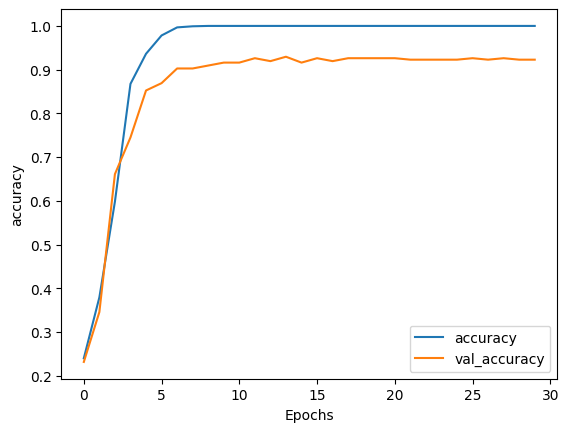

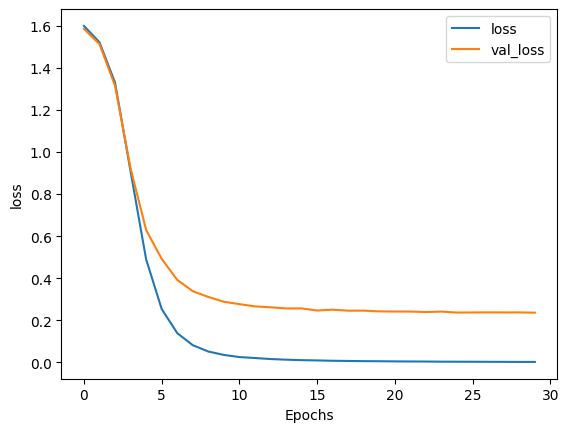

In [93]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")